# COMP9418 Assignment1<br><br>
student:<br>
    z5192086, Pan Luo<br>
    z5181142, Zhidong Luo<br>
    z5190380, Jiawei Ren<br>


In [1]:
# Make division default to floating-point, saving confusion
from __future__ import division
from __future__ import print_function

# Necessary libraries
import numpy as np
import pandas as pd

# combinatorics
from itertools import product, combinations
# ordered dictionaries are useful for keeping ordered sets of varibles
from collections import OrderedDict as odict
#visualise our graph
from graphviz import Digraph

# table formating for screen output
from tabulate import tabulate

# easier debugging display
pd.set_option('display.multi_sparse', False)
from pprint import pprint

# TASK 1

We implement the algorithm described in the task 1. First, delete all the nodes which does not belong to X ∪ Y ∪ Z. Then delete all outgoing edges from nodes in Z. Now we get a new DAG', if two nodes are disconnected in DAG', then they are d-deperated.
<br> The complexity of this algorithm is O(n + e), where n is the number of the nodes and e is the number of the edges.

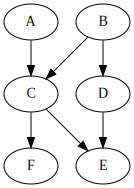

In [2]:
# test graph
t_graph = {
    'A': ['C'],
    'B': ['C', 'D'],
    'C': ['E', 'F'],
    'D': ['E']
}
dot = Digraph(comment='Test Graph')

for v in t_graph:
    dot.node(str(v))

for v in t_graph:
    for w in t_graph[v]:
        dot.edge(str(v), str(w))
dot

Firstly, we convert the graph from adjacent list to adjacent matrix using numpy.<br><br>
Then, we delete all leaf nodes from the graph. This can be done recursively and we just need to compute the row sum of the adjacent matrix. If the row sum is 0, we can say it is a leaf node, then we can delete the corresponding row and column.<br><br>
The third step is to delete all outgoing edges from Z. we can modify the adjacent matrix by position index.<br><br>
Now we have the graph' after preprocessing. Before judging d-separation, we need to convert the graph format from adjacent matrix to the adjacent list.<br><br>
We can reuse the tutorial DFS code and start DFS from each node in X. If a node in Y is visited during DFS, we can say X and Y are not disconnected, which means they are not d-separated. Otherwise, they are d-separated, so we return True.

In [3]:
from itertools import compress
from collections import defaultdict
import numpy as np
# This is the main DFS recursive function
def dfs_r(G, v, colour):
    """
    argument 
    `G`, an adjacency list representation of a graph
    `v`, next vertex to be visited
    `colour`, dictionary with the colour of each node
    """
    # Visited vertices are coloured 'grey'
    colour[v] = 'grey'
    # Let's visit all outgoing edges from v
    for w in G[v]:
        # To avoid loops, we vist check if the next vertex hasn't been visited yet
        if colour[w] == 'white':
            dfs_r(G, w, colour)
    # When we finish the for loop, we know we have visited all nodes from v. It is time to turn it 'black'
    colour[v] = 'black'

# This is an auxiliary DFS function to create and initialize the colour dictionary
def dfs(G, start):
    """
    argument 
    `G`, an adjacency list representation of a graph
    `start`, starting vertex
    """    
    # Create a dictionary with keys as node numbers and values equal to 'white'
    colour = dict([(node, 'white') for node in G.keys()])
    # Call recursive DFS 
    dfs_r(G, start, colour)
    # We can return colour dictionary. It is useful for some operations, such as detecting connected components
    return colour

def remove_leaf_r(matrix, l, union_set):
    # get the number of outgoing edges
    line_sum = np.sum(matrix, axis = 1)
    # get the index of leaf nodes
    bool_list = np.equal(line_sum, 0)
    index_list = [*compress(range(matrix.shape[0]), bool_list)]
    # we cannot delete leaf node which belongs to X ∪ Y ∪ Z
    deleted_list = []
    copied_list = index_list.copy()
    for i in copied_list:
        if l[i] in union_set:
            index_list.remove(i)
        else:
            deleted_list.append(l[i])
    # when we have leaf node to delete
    if len(deleted_list) > 0:
        # delete that leaf node. In numpy matrix, we delete the corresponding row and column
        matrix = np.delete(matrix, index_list, axis = 0)
        matrix = np.delete(matrix, index_list, axis = 1)
        # update the nodes list
        for i in deleted_list:
            l.remove(i)
        # recursively delete leaf nodes from the newly created graph
        matrix = remove_leaf_r(matrix, l, union_set)
    return matrix
    
# time comlexity: O(n + e)    
def d_separation(G,X,Y,Z):
    # get the union set of X ∪ Y ∪ Z
    union_set = set(X) | set(Y) | set(Z)
    # get all nodes name
    nodes = (set(G.keys()) | set(node for children in G.values() for node in children))
    # sort nodes name
    order_node_list = sorted(nodes)
    # represent graph in a adjacent matrix using numpy
    matrix = np.zeros((len(nodes), len(nodes)), dtype = int)
    for key, values in G.items():
        for value in values:
            matrix[order_node_list.index(key), order_node_list.index(value)] = 1
    # recursivly remove leaf nodes
    matrix = remove_leaf_r(matrix, order_node_list, union_set)
    # delete outgoing edges from Z
    for i in set(Z):
        matrix[order_node_list.index(i), np.where(matrix[order_node_list.index(i)] > 0)] = 0
    # represent graph in a adjacent list format using python dictionary
    G = dict()
    for i in order_node_list:
        G[i] = []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i, j] > 0:
                G[order_node_list[i]].append(order_node_list[j])
    # start DFS in newly created graph from each node in set X.
    # if we could reach a node in Y, we say X and Y are not disconnected
    # which means they are not d-seperated
    for i in set(X):
        color = dfs(G, i)
        for j in set(Y):
            if color[j] == 'black':
                return False
    # if X and Y are disconnected in the newly created graph, they are d-sepearted
    return True

##############################
# Test code
##############################
print(d_separation(t_graph, 'A', 'E', 'F'))
print(d_separation(t_graph, 'F', 'D', 'B'))



False
True


# TASK 2
This task is estimating the parameters of a Bayesian Network. We estimate these parameters from "bc 2.csv". Calculate each and every conditional probability for 16 nodes.

In [4]:
def printFactor(f):
    """
    argument 
    `f`, a factor to print on screen
    """
    # Create a empty list that we will fill in with the probability table entries
    table = list()
    
    # Iterate over all keys and probability values in the table
    for key, item in f['table'].items():
        # Convert the tuple to a list to be able to manipulate it
        k = list(key)
        # Append the probability value to the list with key values
        k.append(item)
        # Append an entire row to the table
        table.append(k)
    # dom is used as table header. We need it converted to list
    dom = list(f['dom'])
    # Append a 'Pr' to indicate the probabity column
    dom.append('Pr')
    print(tabulate(table,headers=dom,tablefmt='orgtbl'))
    
def prob(factor, *entry):
    """
    argument 
    `factor`, a dictionary of domain and probability values,
    `entry`, a list of values, one for each variable in the same order as specified in the factor domain.
    
    Returns p(entry)
    """

    return factor['table'][entry]  

def allEqualThisIndex(dict_of_arrays, **fixed_vars):
    """
    Helper function to create a boolean index vector into a tabular data structure,
    such that we return True only for rows of the table where, e.g.
    column_a=fixed_vars['column_a'] and column_b=fixed_vars['column_b'].
    
    This is a simple task, but it's not *quite* obvious
    for various obscure technical reasons.
    
    It is perhaps best explained by an example.
    
    >>> all_equal_this_index(
    ...    {'X': [1, 1, 0], Y: [1, 0, 1]},
    ...    X=1,
    ...    Y=1
    ... )
    [True, False, False]
    """
    # base index is a boolean vector, everywhere true
    first_array = dict_of_arrays[list(dict_of_arrays.keys())[0]]
    index = np.ones_like(first_array, dtype=np.bool_)
    for var_name, var_val in fixed_vars.items():
        index = index & (np.asarray(dict_of_arrays[var_name])==var_val)
    return index

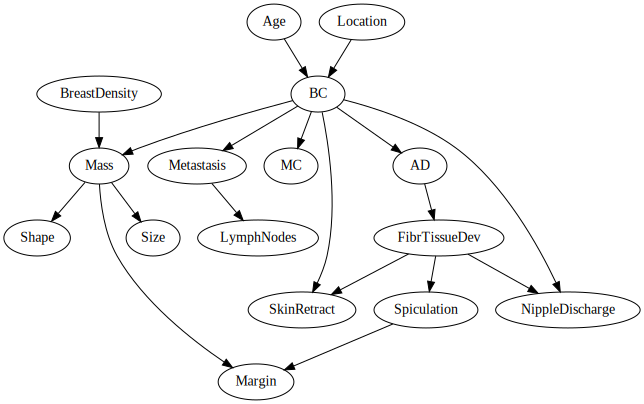

In [5]:
# represent the graph given in the assignment spec in adjacent list formart.
graph = {
    'Age': ['BC'],
    'Location': ['BC'],
    'BC': ['Metastasis', 'MC', 'SkinRetract', 'Mass', 'AD', 'NippleDischarge'],
    'BreastDensity': ['Mass'],
    'Mass': ['Size', 'Shape', 'Margin'],
    'Spiculation': ['Margin'],
    'AD': ['FibrTissueDev'],
    'FibrTissueDev' : ['NippleDischarge', 'SkinRetract', 'Spiculation'],
    'Metastasis': ['LymphNodes']
}

dot = Digraph(comment='BC Graph')

for v in graph:
    dot.node(str(v))

for v in graph:
    for w in graph[v]:
        dot.edge(str(v), str(w))
dot

In [6]:
def estProbTable(data, var_name, parent_names, outcomeSpace):
    """
    Calculate a dictionary probability table by ML given
    `data`, a dictionary or dataframe of observations
    `var_name`, the column of the data to be used for the conditioned variable and
    `var_outcomes`, a tuple of possible outcomes for the conditiona varible and
    `parent_names`, a tuple of columns to be used for the parents and
    `parent_outcomes` a tuple of all possible parent outcomes 
    Return a dictionary containing an estimated conditional probability table.
    """    
    var_outcomes = outcomeSpace[var_name]
    parent_outcomes = [outcomeSpace[var] for var in (parent_names)]
    # cartesian product to generate a table of all possible outcomes
    all_parent_combinations = product(*parent_outcomes)

    prob_table = odict()
    
    for i, parent_combination in enumerate(all_parent_combinations):
        cond_array = []
        parent_vars = dict(zip(parent_names, parent_combination))
        parent_index = allEqualThisIndex(data, **parent_vars)
        for var_outcome in var_outcomes:
            var_index = (np.asarray(data[var_name])==var_outcome)
            prob_table[tuple(list(parent_combination)+[var_outcome])] = (var_index & parent_index).sum()/parent_index.sum()
            
    return {'dom': tuple(list(parent_names)+[var_name]), 'table': prob_table}


##############################
# Test code
##############################
# printFactor(estProbTable(data, 'Age', [], outcomeSpace))

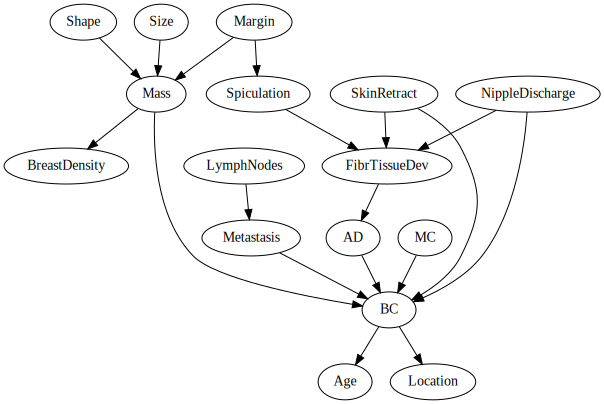

In [7]:
def transposeGraph(G):
    GT = dict((v, []) for v in G)
    for v in G:
        for w in G[v]:
            if w in GT:
                GT[w].append(v)
            else:
                GT[w] = [v]
    return GT

graphT = transposeGraph(graph)

dot = Digraph(comment='Direct transpose graph GT')

for v in graphT:
    dot.node(str(v))

for v in graphT:
    for w in graphT[v]:
        dot.edge(str(v), str(w))
dot

learn_bayes_net(G, file, outcomeSpace, prob_tables) returns a tuple (prob_tables, outcomeSpace). Prob_tables saves all conditional probabilities learned from csv file and outcomeSpace saves all variable names and the possible values for each variable.<br><br>
outcomeSpace can be filled by pandas dataframe operation. prob_tables can be filled by reusing the totorial code.

In [8]:
def learn_bayes_net(G, file, outcomeSpace, prob_tables):
    # read data into a pandas dataframe
    data = pd.read_csv(file)
    # get all column names
    index = data.columns
    # create an empty dictionary for the outcomeSpace
    outcomeSpace = dict()
    # insert values into the outcomeSpace
    for i in range(len(index)):
        outcomeSpace[index[i]] = tuple(data.iloc[:,i].unique())
    # create an empty odict for prob_tables
    prob_tables = odict()
    # reverse each edge
    graphT = transposeGraph(G)
    # Estimate the probability for a single table
    for node, parents in graphT.items():
        prob_tables[node] = estProbTable(data, node, parents, outcomeSpace)
    return prob_tables, outcomeSpace


##############################
# Test code
##############################
prob_tables, outcomeSpace = learn_bayes_net(graph, 'bc 2.csv', {}, {})
print('estimated P(Age)=')
printFactor(prob_tables['Age'])
print('estimated P(BC|Age, Location)=')
printFactor(prob_tables['BC'])

estimated P(Age)=
| Age   |      Pr |
|-------+---------|
| 35-49 | 0.248   |
| 50-74 | 0.50025 |
| >75   | 0.1478  |
| <35   | 0.10395 |
estimated P(BC|Age, Location)=
| Age   | Location    | BC       |         Pr |
|-------+-------------+----------+------------|
| 35-49 | LolwOutQuad | No       | 0.762726   |
| 35-49 | LolwOutQuad | Invasive | 0.140394   |
| 35-49 | LolwOutQuad | Insitu   | 0.0968801  |
| 35-49 | UpOutQuad   | No       | 0.546699   |
| 35-49 | UpOutQuad   | Invasive | 0.198873   |
| 35-49 | UpOutQuad   | Insitu   | 0.254428   |
| 35-49 | UpInQuad    | No       | 0.653481   |
| 35-49 | UpInQuad    | Invasive | 0.160601   |
| 35-49 | UpInQuad    | Insitu   | 0.185918   |
| 35-49 | LowInQuad   | No       | 0.685275   |
| 35-49 | LowInQuad   | Invasive | 0.141586   |
| 35-49 | LowInQuad   | Insitu   | 0.173139   |
| 50-74 | LolwOutQuad | No       | 0.549206   |
| 50-74 | LolwOutQuad | Invasive | 0.30119    |
| 50-74 | LolwOutQuad | Insitu   | 0.149603   |
| 50-74 | UpOut

The size of the joint distribution is 3 * 4 * 4 * 3 * 3 * 2 * 2 * 2 * 3 * 4 * 2 * 2 * 2 * 2 * 2 * 2 = 2654208.

In [9]:
n = 1
for i in outcomeSpace.keys():
    n *= len(outcomeSpace[i])
print(n)

2654208


# TASK 3

The task is aimed to generate new instance from the joint distribution. We use a random number generator to draw a value of each variable X. Then we continue in topological ordering and sample value for its children until all nodes have values. We can generate lots of sample in this way.<br><br>
we reuse the topological sort code in the tutorial and modify it to start from each unvisited node. In this case, we can get the topologal sort of all nodes of the given graph.

In [10]:
def topologicalSort_r(G, v, colour, stack):
    """
    argument 
    `G`, an adjacency list representation of a graph
    `v`, current vertex
    `colour`, colouring dictionary
    `stack`, list with topological ordering of nodes
    """     
    colour[v] = 'grey'
    for w in G[v]:
        if colour[w] == 'white':
            topologicalSort_r(G, w, colour, stack)
    colour[v] = 'black'
    if v not in stack:
        stack.append(v)
    
def topologicalSort(G):
    """
    argument 
    `G`, an adjacency list representation of a graph
    `start`, starting vertex
    """        
    nodes = (set(G.keys()) | set(node for children in G.values() for node in children))
    for i in nodes:
        if i not in G.keys():
            G[i] = []
    colour = dict([(node, 'white') for node in G.keys()])
    # We use a stack to store the topological ordering of the nodes, so we can reverse it later
    stack = []
    # for each unvisited node, we start DFS from it.
    for i in nodes:
        if colour[i] == 'white':
            topologicalSort_r(G, i, colour, stack)
    # return a list in topology order
    return list(reversed(stack))
        
#######################################
# Test code
#######################################
# we use the graph given in the assignment spec to test the order
test_graph = {
    'Age': ['BC'],
    'Location': ['BC'],
    'BC': ['Metastasis', 'MC', 'SkinRetract', 'Mass', 'AD', 'NippleDischarge'],
    'BreastDensity': ['Mass'],
    'Mass': ['Size', 'Shape', 'Margin'],
    'Spiculation': ['Margin'],
    'AD': ['FibrTissueDev'],
    'FibrTissueDev' : ['NippleDischarge', 'SkinRetract', 'Spiculation'],
    'Metastasis': ['LymphNodes']
}

# get the list in topological order of the test graph
order = topologicalSort(test_graph)

generate 1000 * 16 random numbers using numpy and do sampling in topological order. This procedure takes O(n * m) time, where n is the number of samples and m is the number of columns.<br><br>
We start sampling in topological order. For each variable, we firstly get the observation value by list index and we choose current variable value based on the random number generated and the cutoff. After deciding the value, we can fill the value to the list. Details can be found in the comments<br><br>
Finally, we get a 16 * 1000 size list. We can create a pandas dataframe from that list and return df as the return value.

In [11]:
def sampling(sample_size = 1000):
    # generate 16 * 1000 random number in numpy
    random_arr = np.random.rand(sample_size, len(order))
    # to create a pandas dataframe, we need a 2-dimensional list
    result_list = []
    for i in range(len(order)):
        result_list.append([])
    # visit each random number and do the sampling
    for i in range(len(order)):
        # get the obeservation variable names
        dom = prob_tables[order[i]]['dom'][: -1]
        # get the current sampling variable outcomeSpace
        values = outcomeSpace[order[i]]
        # get 1000 random number for current sampling variable
        random_line = random_arr[:, 0]
        # generate 1000 samples for the current sampling variable
        for j in range(sample_size):
            # get the random number
            random_number = random_line[j]
            # get the observation value from the result_list
            # as we do this in topological order, the observation should exist in the result_list
            # suppose we are computing P(X|Y,Z), we read the value of Y and Z from the result_list.
            l = []
            for d in dom:
                l.append(result_list[order.index(d)][j])
            # get the conditional probablity. e.g. P(X|Y=y,Z=z)
            ll = []
            for value in values:
                key = tuple(l + [value])
                ll.append(prob_tables[order[i]]['table'][key])
            # compute the cumsum for the probability and choose the value for the current variable
            # based on the ranmdom number
            for ii in range(1, len(ll) + 1):
                cum_sum_prob = sum(ll[: ii])
                if cum_sum_prob >= random_number:
                    result_list[i].append(outcomeSpace[order[i]][ii - 1])
                    break
    # create a empty dict for creating pandas dataframe
    d = dict()
    for i in range(len(order)):
        d[order[i]] = result_list[i]
    # generate pandas dataframe object and return that object.
    df = pd.DataFrame(d)
    return df

        
#######################################
# Test code
#######################################
# we sample 1000 instance according to the spec
df = sampling(1000)
df

,Age,BreastDensity,Location,BC,Mass,Size,Metastasis,Shape,AD,FibrTissueDev,Spiculation,Margin,SkinRetract,NippleDischarge,MC,LymphNodes
0,35-49,high,LolwOutQuad,No,No,<1cm,no,Other,No,No,No,Well-defined,No,No,No,no
1,>75,medium,LowInQuad,Invasive,Malign,1-3cm,yes,Irregular,Yes,Yes,Yes,Ill-defined,Yes,Yes,Yes,yes
2,50-74,medium,UpOutQuad,No,No,<1cm,no,Other,No,No,No,Well-defined,No,No,No,no
3,50-74,medium,UpInQuad,Invasive,Malign,1-3cm,yes,Irregular,Yes,Yes,Yes,Ill-defined,Yes,Yes,Yes,yes
4,50-74,high,UpOutQuad,No,No,<1cm,no,Other,No,No,No,Well-defined,No,No,No,no
5,50-74,medium,UpInQuad,Invasive,Malign,1-3cm,yes,Irregular,Yes,Yes,Yes,Ill-defined,Yes,Yes,Yes,yes
6,50-74,medium,UpInQuad,Invasive,Malign,1-3cm,yes,Irregular,Yes,Yes,Yes,Ill-defined,Yes,Yes,Yes,yes
7,35-49,high,LolwOutQuad,No,No,<1cm,no,Other,No,No,No,Well-defined,No,No,No,no
8,50-74,medium,UpOutQuad,No,No,<1cm,no,Other,No,No,No,Well-defined,No,No,No,no
9,50-74,medium,UpOutQuad,No,No,<1cm,no,Other,No,No,No,Well-defined,No,No,No,no


# TASK 4

Define the graph and outcomespace

In [12]:
graph = {
    'BreastDensity': ['Mass'],
    'Location': ['BC'],
    'Age': ['BC'],
    'BC': ['Metastasis', 'Mass', 'MC', 'SkinRetract', 'NippleDischarge', 'AD'],
    'Mass': ['Margin', 'Shape', 'Size'],
    'AD': ['FibrTissueDev'],
    'Metastasis': ['LymphNodes'],
    'MC': [],
    'Size': [],
    'Shape': [],
    'FibrTissueDev': ['SkinRetract', 'NippleDischarge', 'Spiculation'],
    'LymphNodes': [],
    'SkinRetract': [],
    'NippleDischarge': [],
    'Spiculation': ['Margin'],
    'Margin': [],
}


# possible outcomes, by variable
outcomeSpace = dict(
    BreastDensity=(0,1,2),
    Location=(0,1,2,3),
    Age=(0,1,2,3),
    Mass=(0,1,2),
    AD=(0,1),
    Metastasis=(0,1),
    MC=(0,1),
    Size=(0,1,2),
    Shape=(0,1,2,3),
    FibrTissueDev=(0,1),
    LymphNodes=(0,1),
    SkinRetract=(0,1),
    NippleDischarge=(0,1),
    Spiculation=(0,1),
    Margin=(0,1),
    BC=(0,1,2),
)

Join function is used for joining the probability of two tables, the function will return a new value of joined probability table

In [13]:
def join(f1, f2, outcomeSpace):
    # First, we need to determine the domain of the new factor. It will be union of the domain in f1 and f2
    # But it is important to eliminate the repetitions
    common_vars = list(f1['dom']) + list(set(f2['dom']) - set(f1['dom']))

    # We will build a table from scratch, starting with an empty list. Later on, we will transform the list into a odict
    table = list()

    # Here is where the magic happens. The product iterator will generate all combinations of varible values
    # as specified in outcomeSpace. Therefore, it will naturally respect observed values
    for entries in product(*[outcomeSpace[node] for node in common_vars]):
        # We need to map the entries to the domain of the factors f1 and f2
        entryDict = dict(zip(common_vars, entries))
        f1_entry = (entryDict[var] for var in f1['dom'])
        f2_entry = (entryDict[var] for var in f2['dom'])

        # Insert your code here
        p1 = prob(f1, *f1_entry)  # Use the fuction prob to calculate the probability in factor f1 for entry f1_entry
        p2 = prob(f2, *f2_entry)  # Use the fuction prob to calculate the probability in factor f2 for entry f2_entry

        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, p1 * p2))
    return {'dom': tuple(common_vars), 'table': odict(table)}

p_point function is used for calculating the joint distribution of all variables in one graph. It will return the joint probability table

In [14]:
def p_joint(outcomeSpace, cond_tables):
    factors = list(cond_tables.keys())
    p = join(cond_tables[factors[0]], cond_tables[factors[1]], outcomeSpace)
    for i in range(2, len(factors)):
        p = join(p, cond_tables[factors[i]], outcomeSpace)
    return p

query function is used for comparing three(because variable "BC" has three possible values) probabilities in the joint probability table and return the maximum one. 

In [15]:
def query(p, q):
    qc = q.copy()
    # create empty list
    res = []
    # get all 3 probabilities
    for i in range(3):
        qc[3] = i
        res.append(p["table"][tuple(qc)])
    # get the muximum probability index
    return res.index(max(res))

Read the data and do some preprocessing, include using integer to replace String, and do the train-test split

In [16]:
from sklearn.model_selection import train_test_split
data = pd.read_csv('bc 2.csv')

data['BreastDensity'].replace(['low', 'medium', 'high'], [0, 1, 2], inplace=True)
data['Location'].replace(['LowInQuad', 'LolwOutQuad', 'UpInQuad', 'UpOutQuad'], [0, 1, 2, 3], inplace=True)
data['Age'].replace(['<35', '35-49', '50-74', '>75'], [0, 1, 2, 3], inplace=True)
data['Mass'].replace(['No', 'Benign', 'Malign'], [0, 1, 2], inplace=True)
data['AD'].replace(['No', 'Yes'], [0, 1], inplace=True)
data['Metastasis'].replace(['no', 'yes'], [0, 1], inplace=True)
data['MC'].replace(['No', 'Yes'], [0, 1], inplace=True)
data['Size'].replace(['<1cm', '1-3cm', '>3cm'], [0, 1, 2], inplace=True)
data['Shape'].replace(['Round', 'Oval', 'Irregular', 'Other'], [0, 1, 2, 3], inplace=True)
data['FibrTissueDev'].replace(['No', 'Yes'], [0, 1], inplace=True)
data['LymphNodes'].replace(['no', 'yes'], [0, 1], inplace=True)
data['SkinRetract'].replace(['No', 'Yes'], [0, 1], inplace=True)
data['NippleDischarge'].replace(['No', 'Yes'], [0, 1], inplace=True)
data['Spiculation'].replace(['No', 'Yes'], [0, 1], inplace=True)
data['Margin'].replace(['Well-defined', 'Ill-defined'], [0, 1], inplace=True)
data['BC'].replace(['No', 'Invasive', 'Insitu'], [0, 1, 2], inplace=True)

train_data,test_data=train_test_split(data,test_size=0.2)

Calculate the joint probability table based on the data,graph and outcomeSpace

In [17]:
graphT = transposeGraph(graph)

cond_t = odict()
for node, parents in graphT.items():
    cond_t[node] = estProbTable(
        train_data,
        node,
        parents,
        outcomeSpace)
p = p_joint(outcomeSpace,cond_t)

Calculate the accracy of Bayes net model. Use each line of the "BC 2.csv" file as a query, and looking for the same 15 variables beside "BC" in the joint probability table, get the maximum probability of "BC" from three different values. Then calculate the accracy based on the correct match of the result of maximum probability between the value in the .csv file. If the predicted value is the same with it in .csv file, then count the correctness plus one. Finally, use the count number diveded by the length of test data, and we get the accuracy of Bayes net model. The final accracy is 0.91475.

In [18]:
def printAcc(p):
    correct_nb = 0 
    for i in range(len(test_data)):
        q = test_data.iloc[i].tolist()
        res = query(p,q)
        if q[3] == res:
            correct_nb += 1
    acc = correct_nb / len(test_data)
    return acc
printAcc(p)

0.91475

We use KNN as the other Machine Learning model. We use sklearn to help us build the model. We use the same size of train-test split. And the final accuracy of KNN model is 0.88925.

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

df = pd.read_csv('bc 2.csv')
df = df.dropna()
Y = df.iloc[:, 3]
df = df.drop("BC", axis=1)
X = df.iloc[:, 0:14]
X = pd.get_dummies(X)
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
eval_set = [(X_test, y_test)]
random_state = 1
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(acc)

0.88925


### That's all for the assignment, the specific problems we meet and their solutions are recorded in our final report.